In [1]:
import getfem as gf
import numpy as np

In [2]:
X = np.array([0.0, 1.0])
mesh = gf.Mesh("cartesian", X)
print(mesh)


BEGIN POINTS LIST

  POINT COUNT 2
  POINT  0  0
  POINT  1  1

END POINTS LIST



BEGIN MESH STRUCTURE DESCRIPTION

  CONVEX COUNT 1
  CONVEX 0    'GT_PK(1,1)'      0  1

END MESH STRUCTURE DESCRIPTION



In [3]:
fb1 = mesh.outer_faces_with_direction([-1.0], 0.01)
print(fb1)

[[0]
 [1]]


In [4]:
fb2 = mesh.outer_faces_with_direction([1.0], 0.01)
print(fb2)

[[0]
 [0]]


In [5]:
print(mesh.outer_faces_in_box([-1.0], [1.0]))

[[0 0]
 [0 1]]


In [6]:
LEFT = 1
RIGHT = 2
mesh.set_region(LEFT, fb1)
mesh.set_region(RIGHT, fb2)
print(mesh)


BEGIN POINTS LIST

  POINT COUNT 2
  POINT  0  0
  POINT  1  1

END POINTS LIST



BEGIN MESH STRUCTURE DESCRIPTION

  CONVEX COUNT 1
  CONVEX 0    'GT_PK(1,1)'      0  1

END MESH STRUCTURE DESCRIPTION
BEGIN REGION 1
0/1 
END REGION 1
BEGIN REGION 2
0/0 
END REGION 2



In [7]:
mfu = gf.MeshFem(mesh, 1)
print(mfu)


BEGIN MESH_FEM

QDIM 1
 BEGIN DOF_ENUMERATION 
 END DOF_ENUMERATION 
END MESH_FEM



In [8]:
f = gf.Fem("FEM_PK(1,1)")
mfu.set_fem(f)
print(mfu)


BEGIN MESH_FEM

QDIM 1
 CONVEX 0 'FEM_PK(1,1)'
 BEGIN DOF_ENUMERATION 
  0:  0 1
 END DOF_ENUMERATION 
END MESH_FEM



In [9]:
element_degree = 1
mfu.set_classical_fem(element_degree)

In [10]:
im = gf.Integ("IM_GAUSS1D(1)")
mim = gf.MeshIm(mesh, im)
print(mim)


BEGIN MESH_IM

 CONVEX 0 'IM_GAUSS1D(1)'
END MESH_IM



In [11]:
md = gf.Model("real")

In [12]:
md.add_fem_variable("u", mfu)

In [13]:
k = 2.0
md.add_initialized_data("k", [k])
md.add_generic_elliptic_brick(mim, "u", "k")

0

In [14]:
md.add_initialized_data("H", [[1.0]])
md.add_initialized_data("r", [0.0])
md.add_generalized_Dirichlet_condition_with_multipliers(mim, "u", mfu, LEFT, "r", "H")

1

In [15]:
F = mfu.eval("1.0")
md.add_initialized_fem_data("F", mfu, F)
md.add_source_term_brick(mim, "u", "F", RIGHT)

2

In [16]:
print(md.brick_list())

Nonemessage from gf_model_get follow:
List of model bricks:
Brick   0     Generic elliptic
  concerned variables: u.
  brick with 1 term
Brick   1 Dirichlet with multipliers brick
  concerned variables: u, mult_on_u.
  brick with 1 term
Brick   2          Source term
  concerned variables: u.
  brick with 1 term




In [17]:
md.solve()

Trace 2 in getfem_models.cc, line 4325: Mass term assembly for Dirichlet condition
Trace 2 in getfem_models.cc, line 4362: Source term assembly for Dirichlet condition
Trace 2 in getfem_models.cc, line 3446: Generic elliptic: generic matrix assembly
Trace 2 in getfem_models.cc, line 4325: Mass term assembly for Dirichlet condition
Trace 2 in getfem_models.cc, line 4362: Source term assembly for Dirichlet condition
Trace 2 in getfem_models.cc, line 3293: Generic source term assembly
Trace 2 in getfem_models.cc, line 3300: Source term: generic source term assembly
Trace 2 in getfem_models.cc, line 3307: Source term: generic matrix assembly


(0, 1)

In [18]:
U = md.variable("u")
print(U)

[0.  0.5]


In [19]:
mfu.export_to_vtk("mfu.vtk", "ascii", mfu, U, "U")

In [20]:
print((F / k)[1])

0.5


In [21]:
import pyvista as pv

pv.start_xvfb()

In [22]:
m = pv.read("mfu.vtk")
print(m)

UnstructuredGrid (0x7f28575374c0)
  N Cells:	1
  N Points:	2
  X Bounds:	0.000e+00, 1.000e+00
  Y Bounds:	0.000e+00, 0.000e+00
  Z Bounds:	0.000e+00, 0.000e+00
  N Arrays:	1



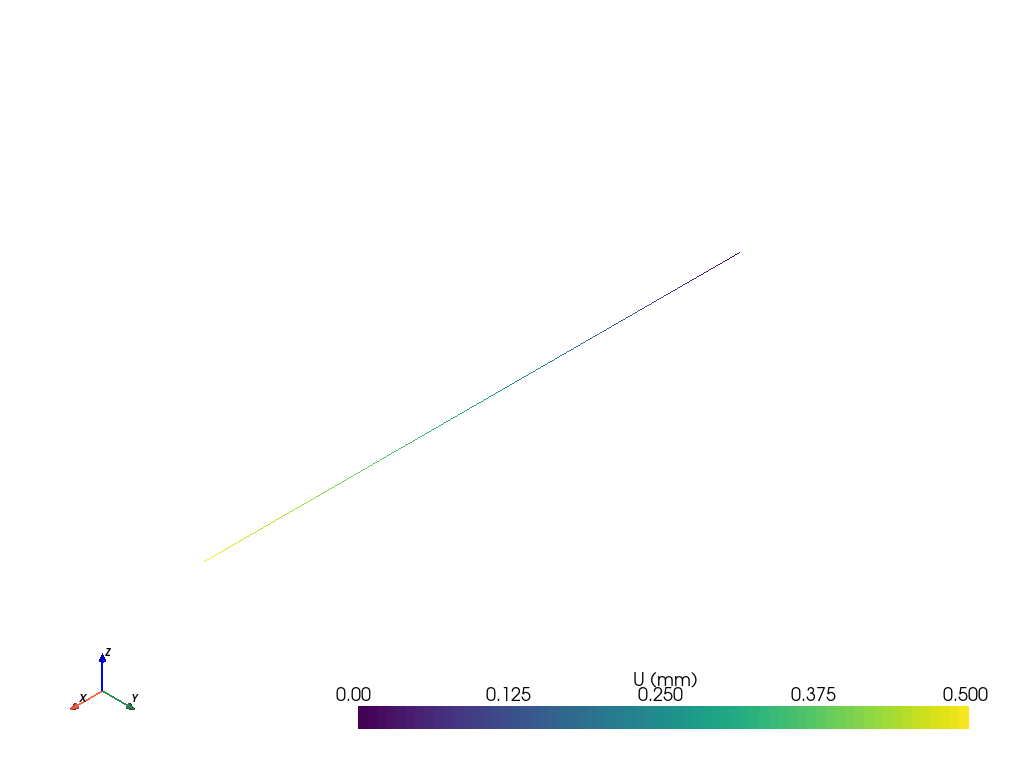

In [23]:
m.plot(jupyter_backend="static", scalar_bar_args={"title": "U (mm)"})

In [24]:
del md
md = gf.Model("real")
md.add_fem_variable("u", mfu)
beta = 1.0 / 4.0
gamma = 1.0 / 2.0
md.add_Newmark_scheme("u", beta, gamma)

In [25]:
m = 3.0e04  # kg
k = 2.94e07  # N/m
c = 2.94e05  # N s/m
T0 = 2.0 * np.pi * np.sqrt(m / k)
dt = T0 / 20.0
md.set_time_step(dt)

In [26]:
MM = gf.Spmat("empty", 2, 2)
MM.add(0, 0, 1.0)
MM.add(1, 1, m)
md.add_explicit_matrix("Dot2_u", "Dot2_u", MM)
DM = gf.Spmat("empty", 2, 2)
DM.add(0, 0, 1.0)
DM.add(1, 1, c)
md.add_explicit_matrix("Dot_u", "Dot_u", DM)
SM = gf.Spmat("empty", 2, 2)
SM.add(0, 0, 1.0)
SM.add(1, 1, k)
md.add_explicit_matrix("u", "u", SM)

2

In [27]:
u0 = 1.0
U0 = np.array([0.0, u0]) # mm
V0 = np.array([0.0, 0.0]) # mm/sec
A0 = np.array([0.0, 0.0]) # mm/sec^2
md.set_variable("Previous_u", U0)
md.set_variable("Previous_Dot_u", V0)
md.set_variable("Previous_Dot2_u", A0)

In [28]:
T = np.array([])
U = np.array([])
for t in np.arange(0.0, 1.0, dt):
    md.solve()
    T = np.append(T, md.get_time())
    U = np.append(U, md.variable("u")[1])
    md.shift_variables_for_time_integration()

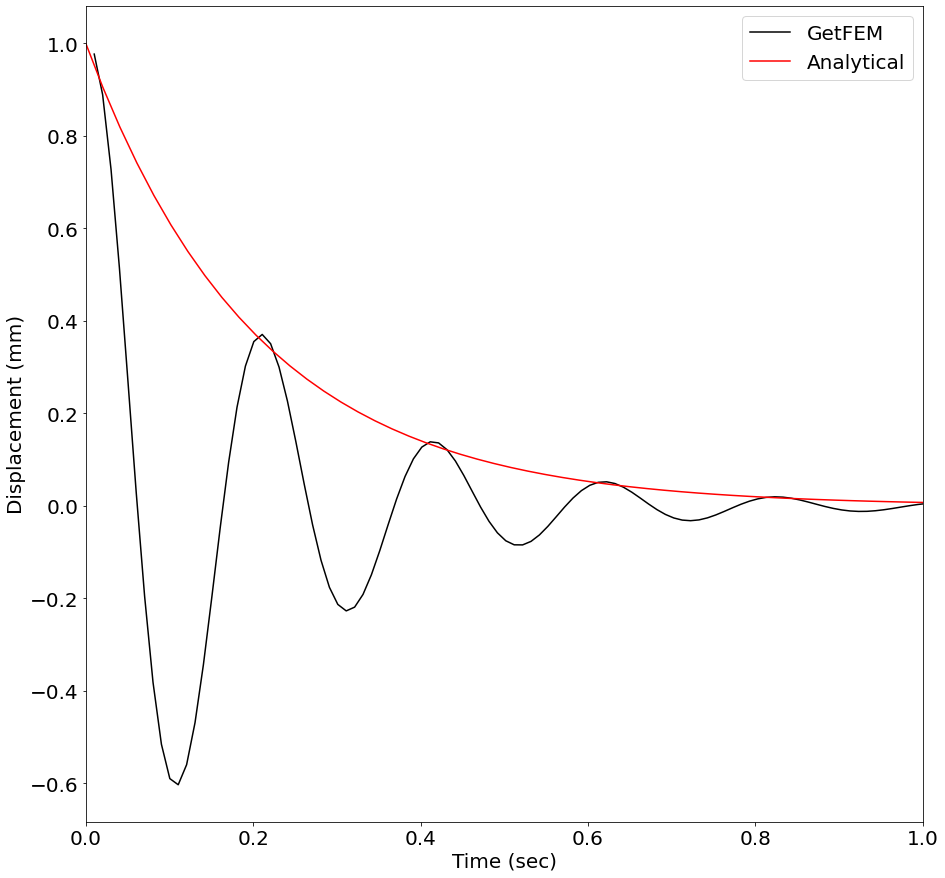

In [29]:
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 20
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1)
ax.plot(T, U, label="GetFEM", color="black")
omega_u = np.sqrt(k / m)
omega_d = np.sqrt(4.0 * m * k - c ** 2) / (2.0 * m)
h = c / (2.0 * np.sqrt(k * m))
n = np.arange(0, 10, 0.1)
ax.plot(
    n * 2.0 * np.pi / omega_d,
    u0 * np.exp(-2.0 * np.pi * n * h * omega_u / omega_d),
    color="red",
    label="Analytical",
)
ax.legend()
ax.set_xlim((0, 1.0))
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Displacement (mm)")
plt.show()